MCS - BeNeFri
<br/>Social Media Analytics, Spring 2020
<br/>Project - Community Detection in a Facebook network
<br/>@authors: Guillaume Chacun, Fabien Vorpe

# Community Detection in a Facebook network

## Dataset

In [1]:
import networkx as nx
from tqdm import tqdm

In [2]:
edges_filename = 'example.txt' #facebook_combined

In [3]:
# Load the Facebook dataset
graph = nx.read_edgelist(f'data/{edges_filename}')
#graph = nx.gnp_random_graph(100, 0.2)

edge_list = ['%i %i {\'weight\': %i}' % (int(d[0]), int(d[1]), int(d[2])) for d in list(graph.edges.data('weight', default=1))]
graph = nx.parse_edgelist(edge_list)

In [4]:
# Explore the properties of the graph

In [5]:
# print number of nodes / edges
print('Number of nodes:', graph.number_of_nodes())
print('Number of edges:', graph.number_of_edges())

Number of nodes: 16
Number of edges: 28


In [6]:
import matplotlib.pyplot as plt
def draw_graph(graph):
    print(graph.edges.data())
    # visualize network
    options = {
        'node_color': (0,0,1,.6),
        'node_size': 30,
        'line_color': (.8,.8,.8,1),
        'linewidths': 0,
        'width': .1,
        'with_labels': 'True',
    }
    nx.draw_networkx(graph, **options)
    plt.show()

## Algorithms implementation

In [7]:
# Implement the Louvain method for community detection.      
def louvain_passage(graph):
    """
    Performs one passage of Louvain's algorithm to detect communities in a graph.
    :param graph: networkx graph
    :returns: dictionary with graph's nodes as keys and communities' id as values
    """
    m = sum([edge[2]['weight'] for edge in graph.edges().data()])
    prev_communities = {}
    communities = {i: i for i in graph.nodes} # keys: nodes' id, values: nodes' community id
    while list(prev_communities.values()) != list(communities.values()): # while communities are changing
        prev_communities = communities.copy()
        
        communities = {k: v 
                       for k, v in sorted(communities.items(), 
                                          key=lambda item: int(item[1]))} # sort by node id (keys)
        for nodei in tqdm(communities.keys()):
            communityi = communities[nodei]
            di = sum([graph.get_edge_data(nodei, neighbor)['weight']
                      for neighbor in graph.neighbors(nodei)])
            neighbor_communities = set(communities[neighbor] for neighbor in graph.neighbors(nodei))
            
            # compute modularity gain for each neighbor community of nodei
            modularity_gains = {} # keys: community' id, values: modularity gain
            for communityj in neighbor_communities:
                nodes_in_communityj = [node for node, community in communities.items() 
                                       if community == communityj]
                dj = sum([graph.get_edge_data(node, neighbor)['weight'] 
                          for node in nodes_in_communityj
                          for neighbor in graph.neighbors(node) 
                          if node != nodei])
                # count number of neighbors of nodei that are in communityj
                links_ij = [graph.get_edge_data(nodei, node)['weight'] if node in graph.neighbors(nodei) else 0 
                            for node in nodes_in_communityj]
                dij = 2 * sum(links_ij)
                # compute modularity
                modularity_gains[communityj] = 1 / (2 * m) * (dij - (di * dj / m))
                
            # update node's community
            modularity_gains = {k: v 
                                for k, v in sorted(modularity_gains.items(), 
                                                   key=lambda item: item[1])} # sort by modularity gain (values)
            communities[nodei] = list(modularity_gains.keys())[-1]
    return communities

In [8]:
def louvain_create_hypernodes(graph, communities):
    """
    Creates the hypernodes graph after one passage of Louvain's aglorithm.
    :param graph: networkx graph
    :param communities: dictionary with graph's nodes as keys and communityies' id as values
    :returns: new networkx graph (communities became hypernodes)
    """
    new_graph = nx.Graph()
    # create hypernodes and reflective edges
    for community in set(communities.values()):
        new_graph.add_node(community)

        # count number of edges in community
        nodes_in_community = [n for n, c in communities.items() if community == c]
        links_intra_community = [1 if neighbor in nodes_in_community else 0 
                                 for node in nodes_in_community
                                 for neighbor in graph.neighbors(node)]
        new_graph.add_edge(community, community, weight=sum(links_intra_community)/2)

    # create inter communities edges
    for community in new_graph.nodes:
        nodes_in_community = [n for n, c in communities.items() if community == c]
        neighbors_of_community = [neighbor
                                  for node in nodes_in_community
                                  for neighbor in graph.neighbors(node) 
                                  if communities[neighbor] != community]
        for other_community in set(communities.values()):
            if other_community != community:
                nodes_in_other_community = [n for n, c in communities.items() if other_community == c]
                nodes_neighbors_in_other_community = [node for node in neighbors_of_community 
                                                      if node in nodes_in_other_community]
                edge_weight = len(nodes_neighbors_in_other_community)
                if other_community not in new_graph.neighbors(community) and edge_weight > 0:
                    new_graph.add_edge(community, other_community, weight=edge_weight)
    return new_graph

In [9]:
def louvain(graph):
    """
    Louvain's algorithm to detect communities in a given graph.
    :param graph: networkx graph
    :returns: graph of communities and a dictionary with graph's nodes as keys and communities' id as values
    """
    all_communities = []
    communities_id = set(graph.nodes())
    passage_id = 0
    while True: # passage
        communities = louvain_passage(graph)
        all_communities.append(communities)

        # check if modif
        if communities_id == set(communities.values()):
            break
        communities_id = set(communities.values())
        
        graph = louvain_create_hypernodes(graph, communities)
        
        passage_id += 1
        print('Graph after passage', passage_id)
        draw_graph(graph)
    return graph, all_communities

In [19]:
# Implement the clustering coefficient for a graph.
def clustering_coefficient(graph):
    """
    Computes the clustering coefficient for each node in a given graph.
    :param graph: networkx graph
    :returns: dictionary with graph's nodes as keys and their clustering coefficient as values
    """
    coeffs = {}
    for v in graph.nodes(): # compute coeff for each node
        neighbors = list(graph.neighbors(v))
        
        connected_pairs_neighbors = []
        for n1 in neighbors: # for each neighbor n1 of node v
            for n2 in graph.neighbors(n1): # for each neighbor n2 of neighbor n1 of node v
                if n2 in neighbors: # if n2 is also a neighbor of node v: (n1,n2) is a connected pair of v's neighbors
                    connected_pairs_neighbors.append((n1, n2))
        # C(v) = #connected pairs of v's neighbors / #pairs of v's neighbors
        nb_pairs_neighnbors = (len(neighbors) * (len(neighbors)-1))
        coeffs[v] = len(connected_pairs_neighbors) / nb_pairs_neighnbors if nb_pairs_neighnbors > 0 else 0
    return coeffs

## Analysis

100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 4007.46it/s]


Graph after passage 1
[('13', '13', {'weight': 1.0}), ('13', '12', {'weight': 3}), ('13', '7', {'weight': 1}), ('13', '3', {'weight': 1}), ('12', '12', {'weight': 8.0}), ('12', '3', {'weight': 1}), ('7', '7', {'weight': 2.0}), ('7', '3', {'weight': 4}), ('3', '3', {'weight': 7.0})]


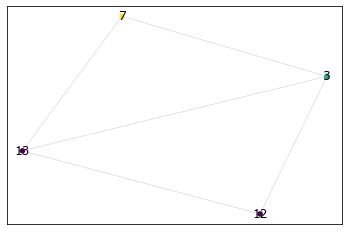

100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<?, ?it/s]
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Graph after passage 2
[('12', '12', {'weight': 2.0}), ('12', '3', {'weight': 3}), ('3', '3', {'weight': 2.0})]


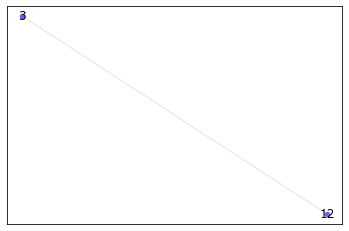

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2012.14it/s]


In [11]:
# Identify users’ communities in the Facebook network using Louvain
new_graph, communities = louvain(graph)

In [12]:
print(f'There are {len(set(communities[-1].values()))} communities.')
#print(communities)

There are 2 communities.


In [13]:
import community
louvain_communities = community.best_partition(graph)
nb_louvain_communities = len(set(louvain_communities.values()))
louvain_communities = {k: v for k, v in sorted(louvain_communities.items(), key=lambda item: item[0])} # sort by key (node id)
print(f'There are {nb_louvain_communities} communities according to Louvain\' method.')

#dendo = community.generate_dendrogram(graph)
#for level in range(len(dendo)) :
#    print("partition at level", level, "is", community.partition_at_level(dendo, level))

There are 2 communities according to Louvain' method.


In [20]:
# Identify the top k users with the highest clustering coefficient in the graph.
# Experiment with different values of k and choose the most appropriate one.
clustering_coefficients = clustering_coefficient(graph)
print(clustering_coefficients)

{'0': 0.3333333333333333, '2': 0.3, '3': 0.0, '4': 0.3333333333333333, '5': 0.16666666666666666, '1': 0.3333333333333333, '6': 0.0, '7': 0.0, '10': 0.2, '11': 0.2, '8': 0.3, '13': 1.0, '12': 0.0, '14': 0.6666666666666666, '9': 0.3333333333333333, '15': 0}


In [21]:
nx.clustering(graph)

{'0': 0.3333333333333333,
 '2': 0.3,
 '3': 0,
 '4': 0.3333333333333333,
 '5': 0.16666666666666666,
 '1': 0.3333333333333333,
 '6': 0,
 '7': 0,
 '10': 0.2,
 '11': 0.2,
 '8': 0.3,
 '13': 1.0,
 '12': 0,
 '14': 0.6666666666666666,
 '9': 0.3333333333333333,
 '15': 0}

In [ ]:
# Evaluate different random walk strategies to spread a message across the network.
# The message should reach as many different communities as possible.

## Visualization

In [ ]:
# Visualize the output of Louvain by coloring the nodes according to their assigned Communities.

In [ ]:
# Visualize the output of applying Random Walk algorithm, by highlighting the sequence of nodes selected in a path.